In [1]:
# Text preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from typing import Union
import numpy as np
import re


# Model/Train Helpers
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D



# PyTorch
import torch
import torch.nn as nn

In [64]:
class TranslGRU:
    def __init__(self, input_size, hidden_size, output_size=None) -> None:
        """
        Define a GRU.
        input_size = number of elements in one-hot encoded vector for a single input.
        hidden_size = desired number of elements in the hidden and cell states
        output_size = None unless want a linear, dense layer ontop of the GRU converting last hidden state to logits of shape (output_size, 1)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def init_weights(self, lam=0.01) -> None:
        """Initialize weight tensors for the model."""
        concat_size = self.input_size + self.hidden_size

        self.W_reset = torch.rand((self.hidden_size, concat_size)) * lam
        self.br = torch.zeros((self.hidden_size, 1)) * lam
        self.W_update = torch.rand((self.hidden_size, concat_size)) * lam
        self.bu = torch.zeros((self.hidden_size, 1)) * lam
        self.W_htilde = torch.rand((self.hidden_size, concat_size)) * lam
        #self.bh = torch.zeros((self.hidden_size, 1)) * lam
        
        self.params = [self.W_reset, self.br, self.W_update, self.bu, self.W_htilde]

        if self.output_size is not None:
            self.W_h2o = torch.rand((self.output_size, self.hidden_size)) * lam
            self.b_h20 = torch.zeros((self.output_size, 1)) * lam
            self.params += [self.W_h2o, self.b_h20]
    
        for p in self.params:
            p.requires_grad = True 
        self.n_parameters = self._count_params()

    def init_states(self) -> torch.tensor:
        """Initialize hidden state. Returns: hidden"""
        hidden = torch.zeros((self.hidden_size, 1))  #(hidden size , batch size)
        return hidden
    
    def step(self, input, hidden) -> torch.tensor:
        """One forward step in the vanilla LSTM to update cell and hidden state. Returns: hidden_new"""
        # Concatenate inputs with incoming hidden state
        concat_raw = torch.cat((input.T, hidden), dim=0)

        # Calc reset gate and apply to hidden state to produce gated/reset hidden state
        r_gate = torch.sigmoid(self.W_reset @ concat_raw + self.br)
        hidden_reset = hidden * r_gate

        # Concatenate inputs with gated hidden state
        concat_gated = torch.cat((input.T, hidden_reset), dim=0)
        # Calculate h tilde, the proposed new hidden state, using the gated concatenation
        h_tilde = torch.tanh(self.W_htilde @ concat_gated)

        # Calc update gate using the raw/ungated concatenation
        u_gate = torch.sigmoid(self.W_update @ concat_raw + self.bu)

        # Update hidden state with (1 - update gate) * hidden_t-1 + (update gate * h tilde):
        hidden_new = (1 - u_gate) * hidden + u_gate * h_tilde
        
        return hidden_new
    

    def forward(self, x, y=None, hidden=None, truncate=None):
        """
        Perform an entire forward pass of a sample to calculate outputs and calculate loss if y is provided.
        Returns logits, loss.
        """
        # Initialize states with zeroes
        if hidden is None:
            hidden = self.init_states()
        
        full_logits = torch.zeros((x.shape[0], self.output_size))
        
        # Pass through input sequentially and update states
        seq_loss = 0
        for t in range(x.shape[0]):
            hidden = self.step(x[t], hidden=hidden)

            # If output shape is not equal to hidden shape, pass through a linear layer to calculate final logits
            if self.output_size is not None:
                logits = (self.W_h2o @ hidden) + self.b_h20
            else:
                logits = hidden
            full_logits[t] = logits.squeeze()
        
            # Calculate loss 
            loss = None
            if y is not None:
                y_size = self.output_size if self.output_size is not None else self.hidden_size
                y_ohe = torch.zeros(y_size)
                y_ohe[y[t]] = 1.0
                loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)

                # if x.shape[0]-t == truncate:
                #     loss.backward()
                #     loss.detach()
                seq_loss += loss.item()
        seq_loss /= x.shape[0]

        self.loss = loss

        return full_logits, seq_loss

    def backprop_update(self, lr) -> None:
        
        # ensure gradients are zerod
        for p in self.params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(self.params):
            if p.grad is None:
                print(i) ##silly debugging
            p.data += -lr * p.grad


    def _count_params(self):
        n_params = 0
        for p in self.params:
            n_params += p.nelement()
        return n_params

In [9]:
def words_to_data(english, french, stoi, special_char:str):
    """
    Takes words list and breaks into training samples such that
    block_size characters are used to predict the following character.
    Returns X, Y (inputs and labels), where each sample in X is a tensor containing block_size elements
    and each sample in Y is a tensor containing one element.
    """

    # Data
    ## block_size = context length: how many chars do we use to predict the next?
    X, Y = [], []
    for en, fr in zip(english, french):

        english_ix = [stoi[special_char]]
        french_ix = [stoi[special_char]]
        for ch in en:
            english_ix.append(stoi[ch])
        english_ix.append(stoi[special_char])
        for ch in fr:
            french_ix.append(stoi[ch])
        french_ix.append(stoi[special_char])
        # x = torch.nn.functional.one_hot(torch.tensor(english_ix), num_classes=len(stoi))
        # y = torch.nn.functional.one_hot(torch.tensor(french_ix), num_classes=len(stoi))
        X.append(torch.tensor(english_ix))
        Y.append(torch.tensor(french_ix))
    # X = torch.tensor(X)
    # Y = torch.tensor(Y)
    # n_samples = X.shape[0]
    # print(f"{ n_samples = }")

    return X, Y


def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [3]:
MAX_FR_CHRS = 100
english, french = [],[]

matches = ["(", "‽", "…", "€"]
with open("./data/rnn_tut_data/eng-fra.txt", encoding="utf-8") as file:
    for line in file:
        line = line.rstrip()
        line = line.replace(u"\u202f", " ")
        line = line.replace(u"\u3000", " ")
        line = line.replace(u"\u2000", " ")
        line = line.replace(u"\u200b", " ")
        line = line.replace(u"\xa0", " ")
        line = line.replace(u"\xad", " ")
        line = line.replace(u"\u2009", " ")
        line = line.replace("ú", "u")
        line = line.replace("–", "-")
        line = line.replace("а", "a")
        line = line.replace("‐", "-")
        if any(s in line for s in matches): ##removes some edge cases
            pass
        else:        
            eng, fra = line.split('\t')
        
        if (len(fra)>MAX_FR_CHRS):
            pass
        else:
            english.append(eng)
            french.append(fra)

In [4]:
print(len(english))
print(len(french))

eng_chars = set(''.join(english))
fra_chars = set(''.join(french))
all_chars = set(''.join(english + french))
print(len(eng_chars))
print(len(fra_chars))
print(len(all_chars))

print("max french length = ", len(max(french, key=len)), "chars")

135332
135332
83
104
104
max french length =  100 chars


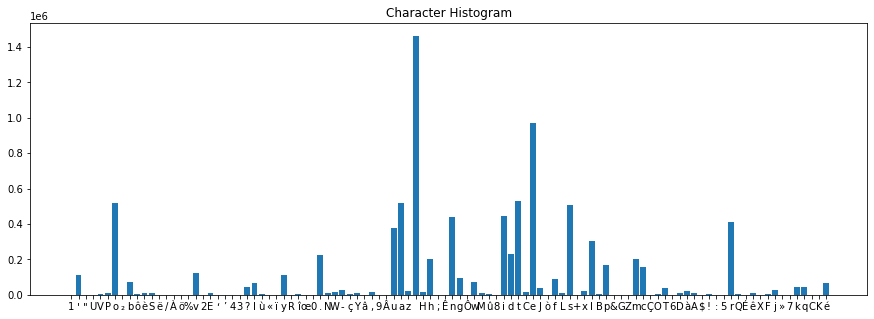

In [10]:
stoi = {s:i+1 for i, s in enumerate(all_chars)} ##create dictionary mapping from char to int
stoi['*'] = 0 #special char
itos = {i:s for s, i in stoi.items()}


corpus = ''.join(english+french)
count_letters = dict()

for c in all_chars:
    count_letters[c] = corpus.count(c)

plt.figure(figsize=(15,5))
plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

# Train

In [65]:
samples = 300
xs, ys = words_to_data(english[:samples], french[:samples], stoi, special_char="*")

n_letters = len(stoi)
hidden_size = 64
model = TranslGRU(input_size=n_letters,
                  hidden_size=hidden_size,
                  output_size=n_letters)
model.init_weights(lam=0.01)

In [93]:
for _ in range(100):
    s_ix = 200 #random.randint(0, len(x)-1)

    x_i, y_i = xs[s_ix], ys[s_ix]
    x_ohe = torch.nn.functional.one_hot(x_i, n_letters)
    x_ohe = torch.unsqueeze(x_ohe, dim=1) #insert 'batch' dim

    logits, loss = model.forward(x_ohe, y_i)

    model.backprop_update(lr=0.1)
    # print(loss)

In [94]:
loss

7.280463297597387

In [95]:
phrase = []
for i in range(logits.shape[0]):
    indx = torch.argmax(logits[0]).item()
    phrase.append(itos[indx])

print("".join(phrase)) 

ooooooooooo


In [38]:
logs = torch.zeros((n_letters, 3))
logs[:, 0] = logits.squeeze()

In [ ]:
torch.nn.functional.softmax(logits, dim=0)